In [2]:
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
from itertools import permutations
import open3d as o3d
#import torch
import pandas as pd
#from origin_apf_test2 import apf_env,distanceCost,Traditional_Apf_Method,cal_angle
#from Model22 import Actor_MultiModal2
#from test import pre_process
import os
import random
from gen_env import generate_columns,generate_spheres,generate_cubes

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [15]:
tree_points = pd.read_csv("./tree2.csv",sep=',',header=None).to_numpy()
def gen_sign(pos_xy,s=True):
    pts = np.hstack((np.tile(pos_xy,(50,1)),np.linspace(-1,5,50).reshape(-1,1)))
    temp = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pts))
    if s:
        temp.paint_uniform_color([4/255.,186/255.,21/255.])
    else:
        temp.paint_uniform_color([240 / 255., 175 / 255., 247 / 255.])
    return temp
def gen_tree(offset_pos):
    return o3d.geometry.PointCloud(o3d.utility.Vector3dVector(tree_points+offset_pos))

In [4]:
pcd = o3d.io.read_point_cloud("D:/pointcloud_base/rollout_21-02-07_03-14-08_pointcloud-unity.ply")
path = pd.read_csv("./loop_6000/path.csv", sep=',', header=None).to_numpy(float)
path2 = path[::5]

In [5]:
points_env = np.array([pt for pt in pcd.points if pt[2] <= 3.])
path = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(path2))
t1 = time.perf_counter()
hull, idx = path.compute_convex_hull()
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull) # 生成三角网
hull_ls.paint_uniform_color((1, 0, 0))
print(time.perf_counter()-t1)

0.0011787999999910426


In [9]:
np.linalg.norm(path2[-2]-path2[-3])

0.6594650350608524

In [6]:
o3d.visualization.draw_geometries(
        [
            o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points_env)),
            path
        ])

In [7]:
o3d.visualization.draw_geometries([pcd])

In [7]:
s_d = [gen_sign([5,16]),gen_sign([10,21],False),
       gen_sign([12,22]),gen_sign([15,24],False),
       gen_sign([9,19]),gen_sign([12,16],False),
       gen_sign([-5,21]),gen_sign([0,19],False)
       ]
s_d2 = [gen_sign([-22,12]),gen_sign([-20,17],False),
        gen_sign([-18,20]),gen_sign([-15,23],False),
        gen_sign([-20,24]),gen_sign([-15,19],False),
        gen_sign([-17,15]),gen_sign([-13.5,17],False),
        gen_sign([-9,8]),gen_sign([-12,10],False),
        gen_sign([-15,6]),gen_sign([-12,7],False),
]
# o3d.visualization.draw_geometries([pcd,*s_d2,*s_d,
#            generate_columns(1.,np.array([-15,15]),4.5),
#            generate_columns(0.8,np.array([-10,10]),8),
#            generate_columns(0.6,np.array([-13,6]),6)
#                                    ])

In [19]:
def cal_angle(v1, v2):
    x = np.dot(v1, v2)
    y1 = np.linalg.norm(v1)
    y2 = np.linalg.norm(v2)

    ans = x / (y1 * y2)
    ans = np.clip(ans, -1, 1)
    return np.arccos(ans) / np.pi * 180
def kinamatic_constrain(v1,v2):
    d = math.hypot(*v2)
    angle = cal_angle(v1,v2)
    if angle <=20:
        return v2
    else:
        # to sphere_coordinate
        theta1 = math.atan2(v1[1],v1[0])
        theta2 = math.atan2(v2[1],v2[0])
        if theta1>=0 and theta2>=0:
            dtheta = theta2-theta1
            if dtheta>=0:
                ret = np.array([d*np.cos(theta1+20/180*np.pi),d*np.sin(theta1+20/180*np.pi)])
            else:
                ret = np.array([d*np.cos(theta1-20/180*np.pi),d*np.sin(theta1-20/180*np.pi)])
        elif theta1>=0 and theta2<0:
            if  -theta2+theta1<np.pi-(-theta2+theta1):
                ret = np.array([d*np.cos(theta1-20/180*np.pi),d*np.sin(theta1-20/180*np.pi)])
            else:
                ret = np.array([d*np.cos(theta1+20/180*np.pi),d*np.sin(theta1+20/180*np.pi)])

        elif theta1 < 0 and theta2 < 0:
            dtheta = theta2-theta1
            if dtheta>=0:
                ret = np.array([d*np.cos(theta1+20/180*np.pi),d*np.sin(theta1+20/180*np.pi)])
            else:
                ret = np.array([d*np.cos(theta1-20/180*np.pi),d*np.sin(theta1-20/180*np.pi)])
        elif theta1 <0 and theta2 >=0:
            if  -theta1+theta2<np.pi-(-theta1+theta2):
                ret = np.array([d*np.cos(theta1+20/180*np.pi),d*np.sin(theta1+20/180*np.pi)])
            else:
                ret = np.array([d*np.cos(theta1-20/180*np.pi),d*np.sin(theta1-20/180*np.pi)])

        return ret

In [26]:
v1 = np.array([-1,1])
v2 = np.array([np.sqrt(3),3])
r= kinamatic_constrain(v1,v2)
print(r)
cal_angle(r,v1)

[-1.4639926   3.13954227]


20.000000000000032

In [2]:
env = apf_env("D:/pointcloud_base/rollout_21-02-07_03-14-08_pointcloud-unity.ply",
              start = np.array([-22.0000008, 13.99999988, 1.8875645]),
                end = np.array([-8.9999992, 19.99999988, 1.8875645]))


________loading point cloud env from path:  D:/pointcloud_base/rollout_21-02-07_03-14-08_pointcloud-unity.ply


In [5]:
np.array([-7,20]),np.array([1,8])
centre_pt_list = [np.array([16.5,12]),np.array([-8.,17])]
t5 = o3d.io.read_point_cloud("./pcd/t5.ply")
o3d.visualization.draw_geometries([t5,
                                   *[gen_sign(pos) for pos in centre_pt_list]])

In [9]:
o3d.visualization.draw_geometries(
    [
        o3d.io.read_point_cloud("./pcd/s1.ply"),gen_sign(np.array([2,3])),
        gen_sign(np.array([2,-3]))
    ]
)

In [39]:
np.linalg.norm(np.array([16.5,10])-np.array([-7,20]))

25.53918557824427

In [7]:
u = random.uniform(0,1)
obs_list = []
obs_info = []
for center_pt in centre_pt_list:
    if u<=0.5:
        gen_center_pt = np.random.multivariate_normal(mean=center_pt,
                                                      cov=np.array([[9, 0],
                                                                    [0, 9]]),
                                                      size= 3
                                                      )
        ret = []
        for x in gen_center_pt:
            rd = random.uniform(0.3,0.7)
            c_pos = x
            h = random.uniform(4,7)
            ret.append(generate_columns(rd,c_pos,h))
            obs_info.append({'type':'Cylinder','radius':rd,'c_p':x,'h':h})

    # ret = [generate_spheres(x,random.uniform(0.4,1.4)) for x in gen_center_pt]
    # ret = [generate_cubes(pcd,random.uniform(0.4,1),x,random.uniform(2,7)) for x in gen_center_pt]
    elif u< -1:
        gen_center_pt = np.random.multivariate_normal(mean=center_pt,
                                                      cov=np.array([[16, 0],
                                                                    [0, 16]]),
                                                      size= 2
                                                      )
        ret = []
        for x in gen_center_pt:
            c_pos = x
            r = random.uniform(0.4, 1.4)
            ret.append(generate_spheres(c_pos,r))
            obs_info.append({'type':'sphere','radius':r,'c_p':x})

    else:
        gen_center_pt = np.random.multivariate_normal(mean=center_pt,
                                                      cov=np.array([[9, 0],
                                                                    [0, 9]]),
                                                      size= 4
                                                      )
        ret = []
        for x in gen_center_pt:
            c_pos = x
            r = random.uniform(0.4, 1.4)
            h = random.uniform(2,7)
            ret.append(generate_cubes(r,c_pos,h))
            obs_info.append({'type':'cube','radius':r,'c_p':x,'h':h})

    obs_list +=ret
o3d.visualization.draw_geometries([t5,*obs_list])

In [24]:
obs_info = np.load("./obs_info.npy",allow_pickle=True)
obs = []
for i in obs_info:
    if i['type']=='Cylinder':
        obs.append(generate_columns(i['radius'],i['c_p'],i['h']))
    else:
        obs.append(generate_cubes(i['radius'],i['c_p'],i['h']))

In [ ]:
x1 = o3d.utility.Vector3dVector(
    np.zeros((3,3))
)
x1+np.ones((1,3))

In [70]:

t7 = o3d.geometry.PointCloud(
)

for o in obs:
    t7 += o

print(max(np.asarray(t7.points)[:,0]),max(np.asarray(t7.points)[:,1]))
print(min(np.asarray(t7.points)[:,0]),min(np.asarray(t7.points)[:,1]))
t7.points = o3d.utility.Vector3dVector(t7.points-
                                       np.expand_dims(np.array([min(np.asarray(t7.points)[:,0]),min(np.asarray(t7.points)[:,1]),0]),0))
print(max(np.asarray(t7.points)[:,0]),max(np.asarray(t7.points)[:,1]))
print(min(np.asarray(t7.points)[:,0]),min(np.asarray(t7.points)[:,1]))
t7_pt = np.array(copy.copy(t7.points))

51.23005130991571 54.4752999271266
1.109522986854131 24.576520948170945
50.12052832306158 29.898778978955654
0.0 0.0


In [73]:
t7 = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(t7_pt-
       np.expand_dims(
           np.array([10,15,0]),0
       )))
o3d.visualization.draw_geometries([t7,gen_sign(np.array([0,0]))])

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


In [30]:
p_o = [np.asarray(o.points) for o in obs_list]
points = np.vstack((t5.points,*p_o))
o3d.io.write_point_cloud("./pcd/t5.ply",o3d.geometry.PointCloud(
    o3d.utility.Vector3dVector(points)
))

True

In [48]:
idxes = [v.grid_index for v in env.vox_map.get_voxels()]
idxes2 = copy.copy(idxes)
idxes2.sort(key=lambda i: np.linalg.norm(env.pos_now - env.vox_map.get_voxel_center_coordinate(i)))

In [46]:
center_coordinates = np.array([env.vox_map.get_voxel_center_coordinate(i) for i in idxes])

In [24]:
base_tree = o3d.io.read_point_cloud("./pcd/tree.ply")
base_tree_points = np.array(base_tree.points)
t2 = o3d.io.read_point_cloud("./pcd/t2.ply")
t2_points = np.array(t2.points)

In [17]:
trees = [gen_tree(np.array([-8,9,0])),
                                   gen_tree(np.array([-5,10,0])),
                                   gen_tree(np.array([-15,10,0])),
                                   gen_tree(np.array([-17,13.5,0])),
                                   gen_tree(np.array([-9,12,0])),
                                   gen_tree(np.array([-9,17,0])),
                                   gen_tree(np.array([-7,14,0])),
                                   gen_tree(np.array([-13.7,12,0])),
                                   gen_tree(np.array([-13.7,14.7,0])),
                                   gen_tree(np.array([-10.5,14.7,0])),]

s_d = [gen_sign([5,16]),gen_sign([10,21],False),
       gen_sign([12,22]),gen_sign([15,24],False),
       gen_sign([9,19]),gen_sign([12,16],False),
       gen_sign([-5,21]),gen_sign([0,19],False)
       ]
s_d2 = [gen_sign([-22,12]),gen_sign([-20,17],False),
        gen_sign([-18,20]),gen_sign([-15,23],False),
        gen_sign([-20,24]),gen_sign([-15,19],False),
        gen_sign([-17,15]),gen_sign([-13.5,17],False),
        gen_sign([-9,8]),gen_sign([-12,10],False),
        gen_sign([-15,6]),gen_sign([-12,7],False),
]

In [61]:
t_x = np.linspace(-30,30,600)
t_y = np.linspace(-10,30,400)
t_z = np.linspace(-0.4,0.8,10)
t = []
for x in t_x:
    for y in t_y:
        for z in t_z:
            t.append([x,y,z])
t = np.array(t)
terrain = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(t))
terrain.paint_uniform_color(np.array([20,20,10])/255.)

PointCloud with 2400000 points.

In [47]:
t3 = o3d.io.read_point_cloud("./pcd/t3.ply")

r=[]
for p1 in os.listdir(r"./res"):
    if p1.endswith('.ply'):
        r.append(o3d.io.read_point_cloud(r"./res/"+p1))


30.0


In [54]:
print(np.min(np.asarray(t3.points)[:,1]))

5.0


In [62]:
o3d.visualization.draw_geometries([t3,*r,terrain])

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


In [11]:
start_pos = np.array([-7,12,1.5])
end_pos = np.array([21,14,1.5])
o3d.visualization.draw_geometries([t5,gen_sign(start_pos[:2]),gen_sign(end_pos[:2],False)])

In [12]:
agent = Actor_MultiModal2()
agent.load_state_dict(pre_process(torch.load(
        r"./opt_500/actor.pkl", map_location=torch.device("cuda"))))

<All keys matched successfully>

In [63]:
env = apf_env("./pcd/t3.ply",
              start_pos,
              end_pos)
env.r0 = 2.
env.x_low_bound = -30
env.x_high_bound = 30
env.y_low_bound = 5
env.y_high_bound = 25

env2 = Traditional_Apf_Method(
        "./pcd/t3.ply", start_pos, end_pos, 0, 0
    )


________loading point cloud env from path:  ./pcd/t3.ply
________loading point cloud env from path:  ./pcd/t3.ply


In [66]:
start_list = [np.asarray(i.points)[0] for i in r]
end_list = [np.asarray(i.points)[-1] for i in r]
ret = []
for i in range(len(start_list)):
    env2.start = start_list[i]
    env2.end = end_list[i]
    env2.reset()
    env2.main()
    ret.append(env2.path)

  6%|▌         | 30/500 [00:02<00:43, 10.84it/s]


-----------------success in reaching goal------------------


  6%|▋         | 32/500 [00:00<00:00, 471.85it/s]


-----------------success in reaching goal------------------


  4%|▍         | 20/500 [00:00<00:00, 513.80it/s]


-----------------success in reaching goal------------------


  5%|▍         | 23/500 [00:00<00:01, 443.50it/s]


-----------------success in reaching goal------------------


 10%|▉         | 48/500 [00:00<00:05, 87.51it/s] 


-----------------success in reaching goal------------------


  7%|▋         | 34/500 [00:00<00:03, 123.97it/s]


-----------------success in reaching goal------------------


  9%|▉         | 44/500 [00:00<00:06, 70.36it/s]


-----------------success in reaching goal------------------


 11%|█         | 54/500 [00:00<00:04, 111.18it/s]


-----------------success in reaching goal------------------


 11%|█         | 56/500 [00:00<00:04, 91.60it/s] 


-----------------success in reaching goal------------------


 15%|█▌        | 77/500 [00:00<00:01, 229.10it/s]


-----------------success in reaching goal------------------


  7%|▋         | 33/500 [00:00<00:00, 517.01it/s]


-----------------success in reaching goal------------------


  8%|▊         | 39/500 [00:00<00:04, 108.62it/s]


-----------------success in reaching goal------------------


  3%|▎         | 16/500 [00:00<00:09, 50.29it/s]


-----------------success in reaching goal------------------


  6%|▌         | 28/500 [00:00<00:01, 384.59it/s]


-----------------success in reaching goal------------------


  7%|▋         | 36/500 [00:00<00:01, 401.07it/s]


-----------------success in reaching goal------------------


 26%|██▌       | 129/500 [00:02<00:07, 52.92it/s]

-----------------success in reaching goal------------------


In [68]:
ret_pcd = []
for re_ in ret:
    tmp = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(np.asarray(re_)))
    tmp .paint_uniform_color(np.array([255,0,0])/255)
    ret_pcd.append(tmp)


In [70]:
signs_1 = [gen_sign(s[:2]) for s in start_list]
signs_2 = [gen_sign(s[:2],False) for s in end_list]
o3d.visualization.draw_geometries([t3,*r,terrain,*ret_pcd,*signs_1,*signs_2])

In [71]:
def calc_bending(waypts):
    ret = 0
    for i in range(len(waypts) - 2):
        v1 = waypts[i + 1][:2] - waypts[i][:2]
        v2 = waypts[i + 2][:2] - waypts[i + 1][:2]
        ret += cal_angle(v1, v2) / 60
    ret = ret / (len(waypts) - 2)
    # assert ret < 1.4,(ret,waypts)
    return ret

def calc_dist(waypts):
    ret = 0
    line_dist = distanceCost(waypts[0], waypts[-1])
    for i in range(len(waypts) - 1):
        ret += distanceCost(waypts[i + 1], waypts[i])
    return ret / line_dist
def calc_safety(path,pcd):
    tree = o3d.geometry.KDTreeFlann(pcd)
    d = 0
    for pt in path[::5]:
        ret = tree.search_knn_vector_3d(pt,50)
        d+=sum(ret[2])

    return d/(path.shape[0]/5)
def get_reward(path:np.ndarray):
    # r1 theta and bending
    # r2 safe d
    r1 = max(calc_bending(path) * -2.5, -5)
    r2 = calc_dist(path) * -1
    #r3 = calc_safety(pos) * -5
    r3 =0
    return (r1,r2,r3)


In [78]:
r_path = [np.asarray(i.points) for i in r]
cost1 = [(10*calc_bending(i)+100*calc_dist(i)+calc_safety(i,env2.pcd)) for i in r_path]
cost2 = [(10*calc_bending(np.asarray(i))+100*calc_dist(np.asarray(i))+calc_safety(np.asarray(i),env2.pcd)) for i in ret]

In [82]:
print(np.mean(cost1),np.mean(cost2))

185.37776930125915 263.14336722886605


In [ ]:
env.get_observation(np.array([21,14,1.1]))


In [22]:
env.vox_map

VoxelGrid with 14 voxels.

In [23]:
o3d.visualization.draw_geometries([env.vox_map])

In [14]:
o3d.visualization.draw_geometries([o3d.geometry.PointCloud(
    o3d.utility.Vector3dVector(np.vstack((env.path[:9],env.path[21:])))
)])
p2 = o3d.geometry.PointCloud(
    o3d.utility.Vector3dVector(np.vstack((env.path[:9],env.path[21:])))
)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 0

In [24]:
for a,b,c in os.walk("./res/res2"):
    print(a,b,c)
c = [f for f in c if f.endswith('ply')]

./res/res2 [] ['path_0.csv', 'path_1.csv', 'path_2.csv', 'r17.ply', 'r18.ply', 'r19.ply']


In [25]:
path_gen = [o3d.io.read_point_cloud(r'./res/res2/'+p) for p in c]


In [26]:
color_set = [
    np.array([253,231,36])/255.,
    np.array([107,205,88])/255.,
    np.array([53,183,120])/255.,
    np.array([30,156,136])/255.,
    np.array([37,130,141])/255.,
    np.array([48,103,141])/255.,
    np.array([61,73,137])/255.,
    np.array([71,39,119])/255.,
    np.array([30,156,136])/255.,
    np.array([180,221,43])/255.,
    np.array([48,103,141])/255.,
    np.array([71,39,119])/255.,
    np.array([255,0,255])/255.,
    np.array([255,231,36])/255.,
    np.array([255,0,128])/255.,
    np.array([61,73,137])/255.,
]
for p,color_ in zip(path_gen,color_set):
    p.paint_uniform_color(color_)

In [28]:
t_x = np.linspace(-30,30,1000)
t_y = np.linspace(5,35,500)
t_z = np.linspace(-0.4,0.8,6)
t = []
for x in t_x:
    for y in t_y:
        for z in t_z:
            t.append([x,y,z])

In [91]:
np.arange(20)[::3]

array([ 0,  3,  6,  9, 12, 15, 18])

In [99]:
for i,p in enumerate(path_gen):
    np.savetxt("./res/res2/path_{}.csv".format(i),np.asarray(p.points)[::3],delimiter=',')

In [32]:
t = np.array(t)
terrain = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(t))
terrain.paint_uniform_color(np.array([20,20,10])/255.)
t3.paint_uniform_color(np.array([166,33,33])/255.)

PointCloud with 3666585 points.

In [33]:
o3d.visualization.draw_geometries([terrain])

In [31]:
t3 = o3d.io.read_point_cloud("./pcd/t5.ply")

In [34]:
points_path_gen = [np.asarray(p.points) for p in path_gen]

In [36]:
signs_start = [gen_sign(p[0][:2]) for p in points_path_gen]
signs_end = [gen_sign(p[-1][:2],False) for p in points_path_gen]

In [37]:
o3d.visualization.draw_geometries([t5,terrain,*path_gen,*signs_start,*signs_end])

In [105]:
np.linalg.norm(points_path_gen[1][3]-points_path_gen[1][4])

0.2795418262481698

In [7]:
waypt = np.array([[18,-15,2,0,0,90],
[18,-13,2,0,0,110],
[17,-11,2,0,0,110],
[18.,-9.5,2,0,0,110],
[18.,-7.5,2,0,0,135],
[17.5,-6.5,2,0,0,135],
[17.,-5.5,2,0,0,135],
[15.5,-4.5,2,0,0,135],
[14.5,-3.5,2,0,0,135],
[13.5,-2.5,2,0,0,120],
[12.5,-1,2,0,0,120],
[13.5,0,2,0,0,120],
[13,2,2,0,0,120],
[11.,5,2,0,0,120],
[10.,7,2,0,0,120],
[9,9,2,0,0,120],
[9.5,11,2,0,0,90],
[9.5,13,2,0,0,90],
[8.5,15,2,0,0,120]])
waypt = np.hstack((waypt[:,0:3],np.expand_dims(waypt[:,-1],1)))

In [30]:
np.save("./res/avoidance4.npy",waypt)

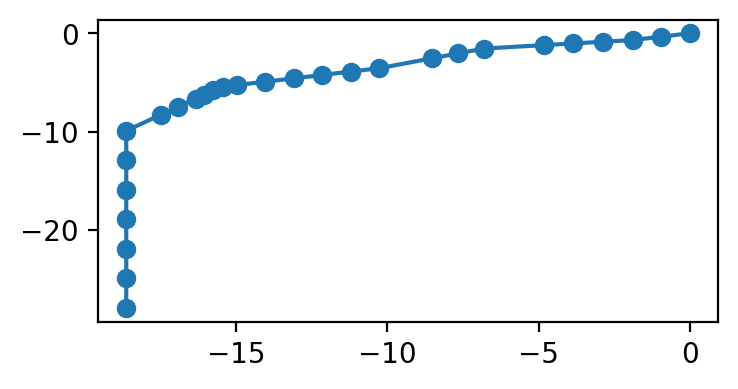

In [81]:

waypt = np.load(r"./res/avoidance4.npy")
traj = np.load(r"./res/avoidance4_traj.npy")
fg = plt.figure(figsize=(4, 2), dpi=200)

plt.plot(waypt[:,0],waypt[:,1])
plt.scatter(waypt[:,0],waypt[:,1])



In [35]:
k0 = 1
r0 = 0.5
f1 = lambda x:min(-np.exp(k0*(1/r0-1/(2*r0-x))),-0.1)
x = np.linspace(r0,2*r0,1000)
y = [f1(xx) for xx in x]



E:\Anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


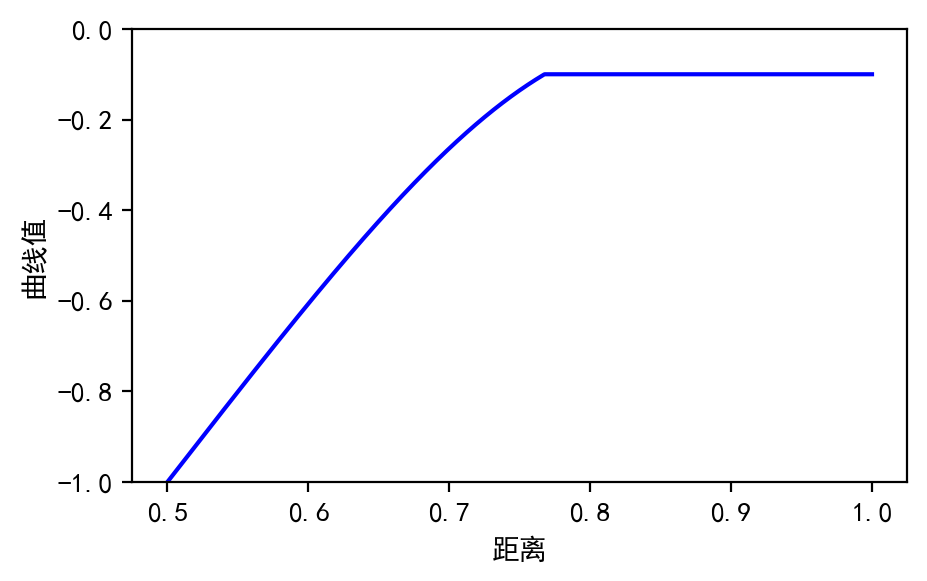

In [36]:
fig = plt.figure(figsize=(5, 3), dpi=200)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
ax = plt.gca()
ax.set_ylim(-1,0)
ax.set_xlabel('距离')
ax.set_ylabel('曲线值')
plt.plot(x,y,color = 'b')

fig.patch.set_facecolor('white')
#plt.rcParams['axes.facecolor'] = 'white'
plt.show()


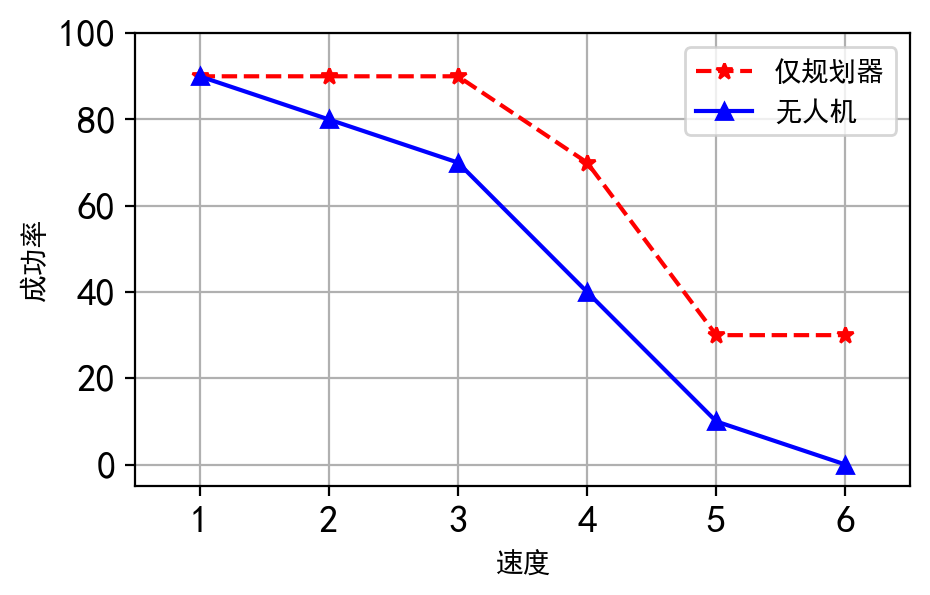

In [13]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(5, 3), dpi=200)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
ax = plt.gca()
ax.set_ylim(-5,100)
ax.set_xlim(0.5,6.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
x_major_locator=MultipleLocator(1)#以每15显示
y_major_locator=MultipleLocator(20)#以每3显示
x=[90,80,70,40,10,0]
y=range(1,len(x)+1)
x2 = [90,90,90,70,30,30]
#plt.plot(y,x,'b')
plt.plot(y,x2,'r--',marker='*',label='仅规划器')
plt.plot(y,x,color='b',marker='^',label='无人机')
ax.legend()
ax.set_xlabel('速度')
ax.set_ylabel('成功率')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
fig.patch.set_facecolor('white')
plt.grid()
#plt.rcParams['axes.facecolor'] = 'white'
plt.show()

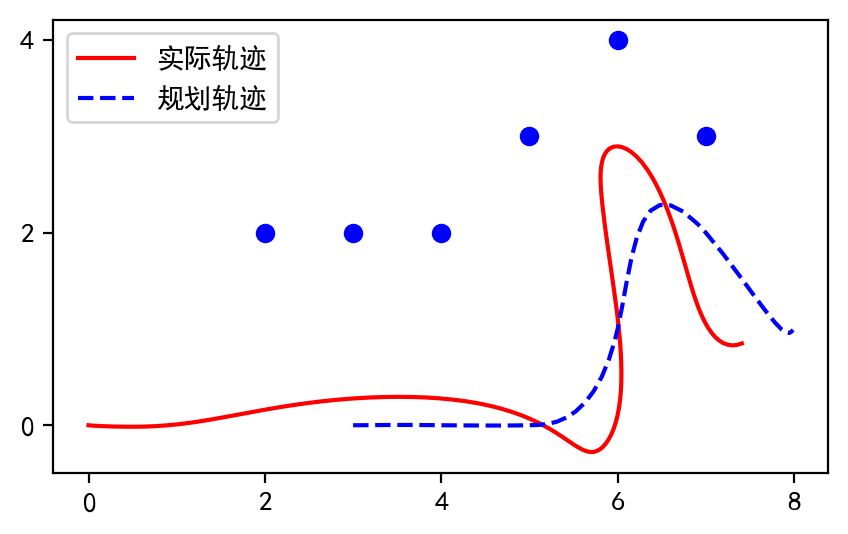

In [69]:
traj2 = np.load("./res/avoidance5_traj.npy",allow_pickle=True)
traj2_real = np.load("./res/avoidance5_real3.npy",allow_pickle=True)
traj2[:,:2]-=traj2[0,:2]
traj2[:,:2]+=np.tile(np.array([3,0]),(traj2.shape[0],1))
pos_xy_real=traj2_real[:,:2]
pos_xy_real-=pos_xy_real[0,:2]
#pos_xy_real+=np.tile(np.array([-0.75,0.5]),(traj2_real.shape[0],1))
part = []
for i in range(pos_xy_real.shape[0]):
    part.append(pos_xy_real[i])
    if pos_xy_real[i][0]>9.3:
        break

part = np.array(part)
fig = plt.figure(figsize=(5, 3), dpi=200)
ax = plt.gca()
# ax.set_ylim(-2,8)
# ax.set_xlim(-2,8)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))
waypt=np.array([[2,2],[3,2],[4,2],[5,3],[6,4],[7,3]])
plt.plot(part[:,0],part[:,1], 'r',label='实际轨迹')
plt.scatter(waypt[:,0],waypt[:,1],color='b')
plt.plot(traj2[:,0],traj2[:,1],'b--',label='规划轨迹')
#plt.grid()
plt.legend()

In [28]:
np.save("./res/avoidance5_realold.npy",traj2_real)

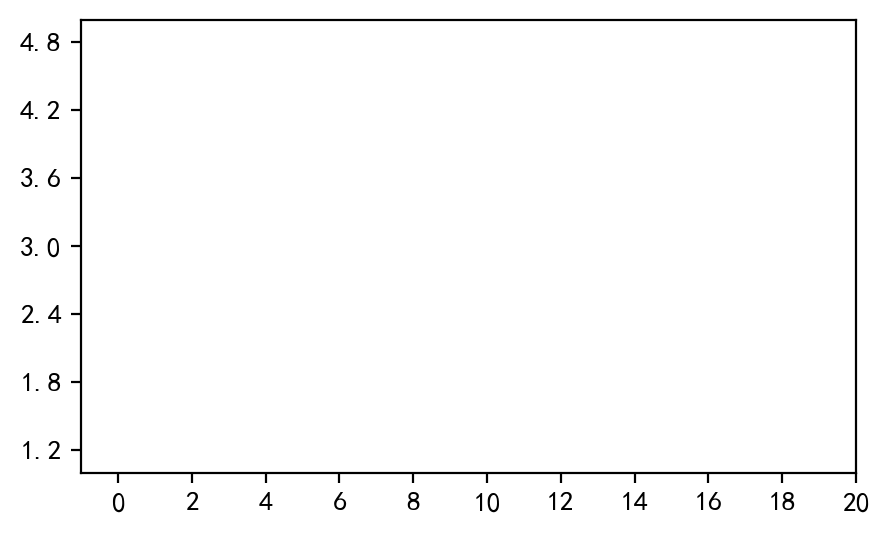

In [22]:
rwd=pd.read_csv(r"./rwdcsv/reward_list_0-9999_2.csv",sep=',',header=None).to_numpy().squeeze()[500:2000]
# for i in range(400,rwd.shape[0]):
#     rwd[i]=max(100+random.random()*30,rwd[i])

fig2 = plt.figure(figsize=(5, 3), dpi=200)
ax = plt.gca()
#plt.grid()
ax.set_ylim(1,5)
ax.set_xlim(-1,20)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(0.6))
#plt.plot(range(rwd.shape[0]),rwd)


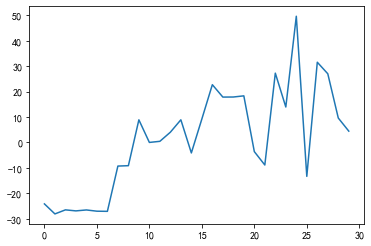

In [137]:
interval = 50
n= int(np.floor(rwd.shape[0]/interval))
avg = [np.mean(rwd[int(i)*interval:int(i+1)*interval-1]) for i in range(n)]
plt.plot(np.arange(n),avg
         )